In [3]:
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error


# Data Preprocessing and Exploration

In [4]:
# ===================== LOAD DATA =====================
sales = pd.read_csv("Pizza_Sale.csv")
ingredients = pd.read_csv("Pizza_ingredients.csv")

print("Initial Sales Data Shape:", sales.shape)
print("Initial Ingredients Data Shape:", ingredients.shape)

print("\nMissing Values in Sales Data:\n", sales.isna().sum())
print("\nMissing Values in Ingredients Data:\n", ingredients.isna().sum())

print("\nPizza Category Value Counts (Before Filling):")
print(sales['pizza_category'].value_counts(dropna=False))

# ===================== Fill Missing Total Price =====================
sales['total_price'] = sales['total_price'].fillna(sales['unit_price'] * sales['quantity'])
print("\nMissing 'total_price' after fill:", sales['total_price'].isna().sum())

# ===================== Fill Missing Pizza Category =====================
category_map = (
    sales[['pizza_name_id', 'pizza_category']]
    .dropna()
    .drop_duplicates(subset='pizza_name_id')
    .set_index('pizza_name_id')['pizza_category']
)
sales['pizza_category'] = sales['pizza_category'].fillna(sales['pizza_name_id'].map(category_map))

print("\nPizza Category Value Counts (After Filling):")
print(sales['pizza_category'].value_counts(dropna=False))

# ===================== Fill Missing Pizza Ingredients =====================
ingr_map = (
    sales[['pizza_name', 'pizza_ingredients']]
    .dropna()
    .drop_duplicates(subset='pizza_name')
    .set_index('pizza_name')['pizza_ingredients']
)
sales['pizza_ingredients'] = sales['pizza_ingredients'].fillna(sales['pizza_name'].map(ingr_map))

print("\nMissing 'pizza_ingredients' after fill:", sales['pizza_ingredients'].isna().sum())

# ===================== Fill Missing Pizza Name =====================
name_map = (
    sales[['pizza_ingredients', 'pizza_name']]
    .dropna()
    .drop_duplicates(subset='pizza_ingredients')
    .set_index('pizza_ingredients')['pizza_name']
)
sales['pizza_name'] = sales['pizza_name'].fillna(sales['pizza_ingredients'].map(name_map))

print("\nMissing 'pizza_name' after fill:", sales['pizza_name'].isna().sum())
print("\nPizza Name Value Counts (sample):")
print(sales['pizza_name'].value_counts().head())

# ===================== Fill Missing Pizza Name ID =====================
nameid_map = (
    sales[['pizza_name', 'pizza_name_id']]
    .dropna()
    .drop_duplicates(subset='pizza_name')
    .set_index('pizza_name')['pizza_name_id']
)
sales['pizza_name_id'] = sales['pizza_name_id'].fillna(sales['pizza_name'].map(nameid_map))

print("\nMissing 'pizza_name_id' after fill:", sales['pizza_name_id'].isna().sum())

# ===================== Fill Missing Ingredients Quantities =====================
mean_qty = ingredients.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()
ingredients['Items_Qty_In_Grams'] = ingredients['Items_Qty_In_Grams'].fillna(ingredients['pizza_name_id'].map(mean_qty))

print("\nMissing 'Items_Qty_In_Grams' after fill:", ingredients['Items_Qty_In_Grams'].isna().sum())

# ===================== Merge Sales and Ingredients =====================
merged = pd.merge(sales, ingredients, on='pizza_name_id', how='left')
print("\nMerged Data Shape:", merged.shape)

# Drop duplicate info and rename for clarity
merged.drop(columns=['pizza_name_y', 'pizza_ingredients_y'], inplace=True)
merged.rename(columns={'pizza_name_x': 'pizza_name', 'pizza_ingredients_x': 'pizza_ingredients'}, inplace=True)

# Drop duplicates
before = merged.shape[0]
merged = merged.drop_duplicates()
after = merged.shape[0]
print(f"\nDropped {before - after} duplicate rows. Final Shape: {merged.shape}")

# ===================== Feature Engineering - Date =====================
def extract_date(date):
    formats = ['%d-%m-%Y', '%d/%m/%Y', '%m/%d/%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT

merged['order_date'] = merged['order_date'].apply(extract_date)
merged['day_of_week'] = merged['order_date'].dt.dayofweek
merged['month'] = merged['order_date'].dt.month
merged['week'] = merged['order_date'].dt.isocalendar().week
merged['year'] = merged['order_date'].dt.year

print("\nDate Features Sample:")
print(merged[['order_date', 'day_of_week', 'month', 'week', 'year']].head())

# ===================== Feature Engineering - Time =====================
def extract_time(time_str):
    formats = ['%H:%M:%S', '%I:%M:%S %p']
    for fmt in formats:
        try:
            return pd.to_datetime(time_str, format=fmt)
        except ValueError:
            continue
    return pd.NaT

merged['order_time'] = merged['order_time'].apply(extract_time)
merged['hour'] = merged['order_time'].dt.hour
merged['minute'] = merged['order_time'].dt.minute
merged['second'] = merged['order_time'].dt.second

print("\nTime Features Sample:")
print(merged[['order_time', 'hour', 'minute', 'second']].head())

# ===================== Add Holiday & Promotion Flags (Adding a promotion flag for Friday (4) and Saturday (5)) =====================
us_holidays = holidays.US()
merged['holiday'] = merged['order_date'].apply(lambda x: "Yes" if x in us_holidays else "No")
merged['promotion'] = merged['order_date'].dt.weekday.apply(lambda x: 1 if x in [4, 5] else 0)

print("\nHoliday and Promotion Flags Sample:")
print(merged[['order_date', 'holiday', 'promotion']].head())

# ===================== Final Data Check =====================
print("\nFinal Shape:", merged.shape)
print("\nMissing Values After All Steps:\n", merged.isna().sum())
print("\nFinal Value Counts - Pizza Category:")
print(merged['pizza_category'].value_counts())
print("\nFinal Value Counts - Holiday Flag:")
print(merged['holiday'].value_counts())
print("\nFinal Value Counts - Promotion Flag:")
print(merged['promotion'].value_counts())
merged.head()


Initial Sales Data Shape: (48620, 12)
Initial Ingredients Data Shape: (518, 4)

Missing Values in Sales Data:
 pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

Missing Values in Ingredients Data:
 pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

Pizza Category Value Counts (Before Filling):
pizza_category
Classic    14572
Supreme    11771
Veggie     11442
Chicken    10812
NaN           23
Name: count, dtype: int64

Missing 'total_price' after fill: 0

Pizza Category Value Counts (After Filling):
pizza_category
Classic    14579
Supreme    11777
Veggie     11449
Chicken    10815
Name: count, dtype: int64

Missing 'pizza_ingredients' after fill: 0

Missing 'pizza_name' after fill:

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,...,Items_Qty_In_Grams,day_of_week,month,week,year,hour,minute,second,holiday,promotion
0,1,1,hawaiian_m,1,2015-01-01,1900-01-01 11:38:36,13.25,13.25,M,Classic,...,25.0,3,1,1,2015,11,38,36,Yes,0
1,1,1,hawaiian_m,1,2015-01-01,1900-01-01 11:38:36,13.25,13.25,M,Classic,...,30.0,3,1,1,2015,11,38,36,Yes,0
2,1,1,hawaiian_m,1,2015-01-01,1900-01-01 11:38:36,13.25,13.25,M,Classic,...,20.0,3,1,1,2015,11,38,36,Yes,0
3,2,2,classic_dlx_m,1,2015-01-01,1900-01-01 11:57:40,16.00,16.00,M,Classic,...,40.0,3,1,1,2015,11,57,40,Yes,0
6,2,2,classic_dlx_m,1,2015-01-01,1900-01-01 11:57:40,16.00,16.00,M,Classic,...,10.0,3,1,1,2015,11,57,40,Yes,0


# Data Visualization

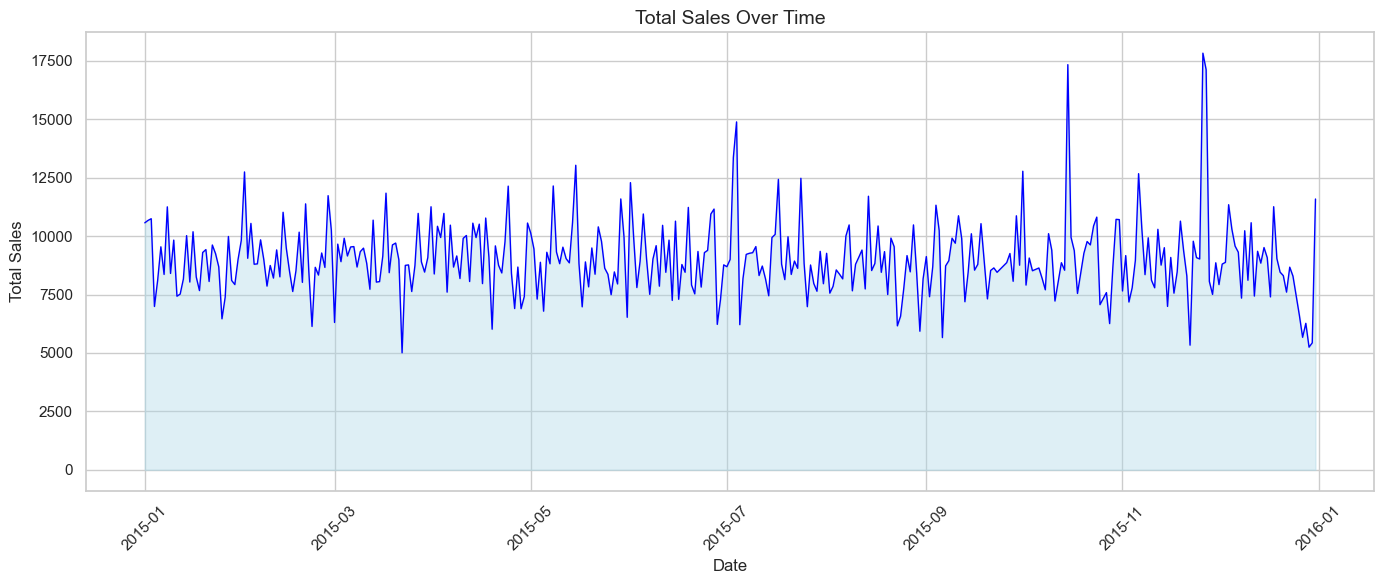

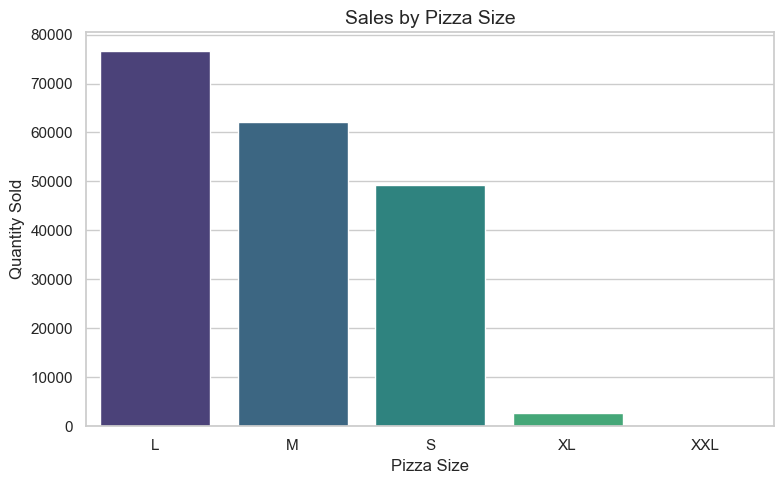

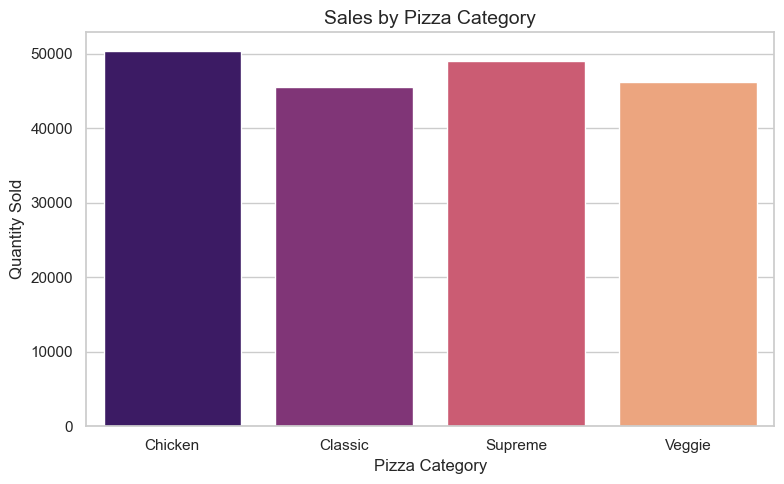

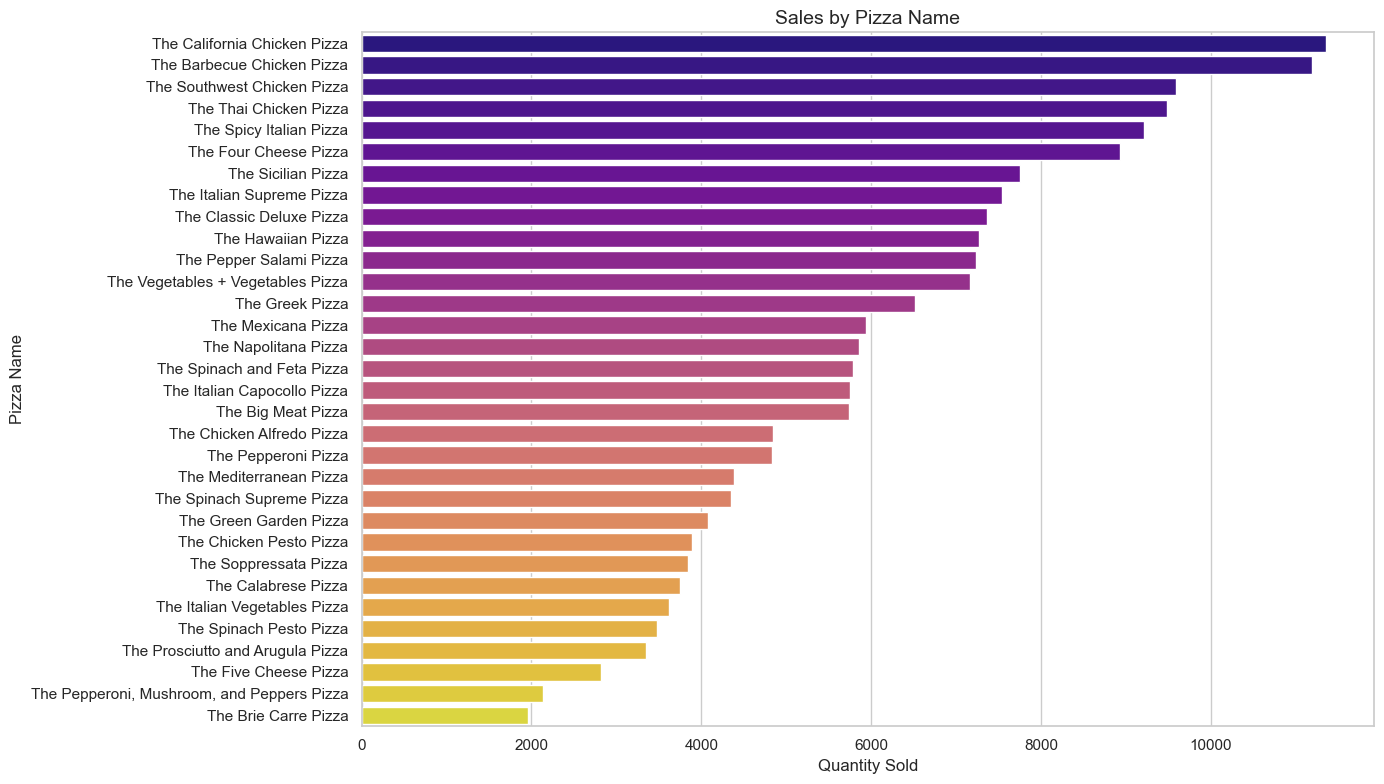

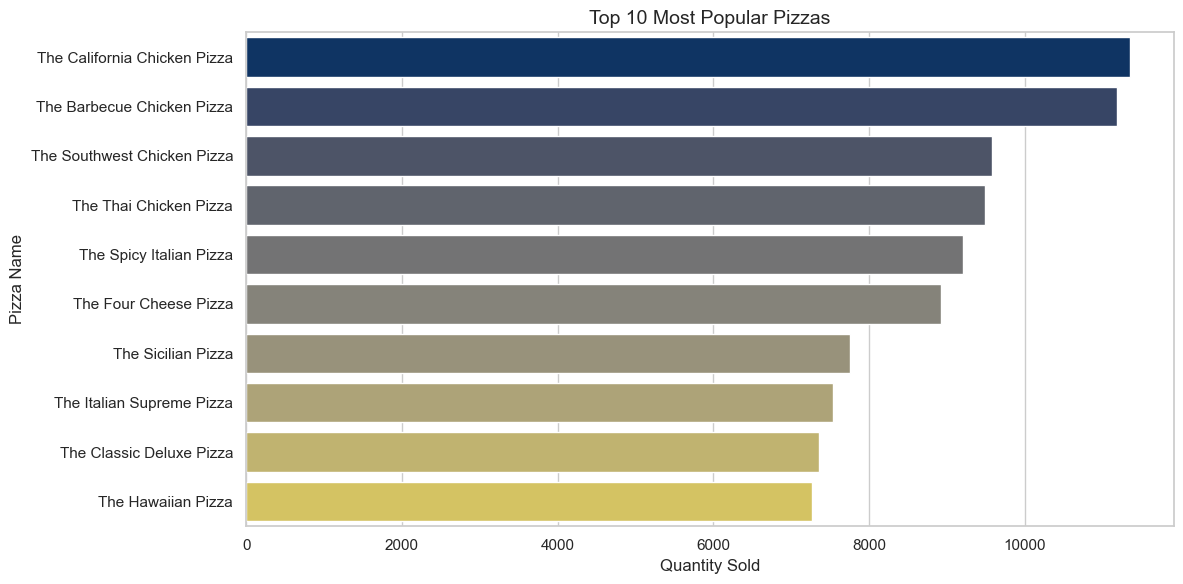

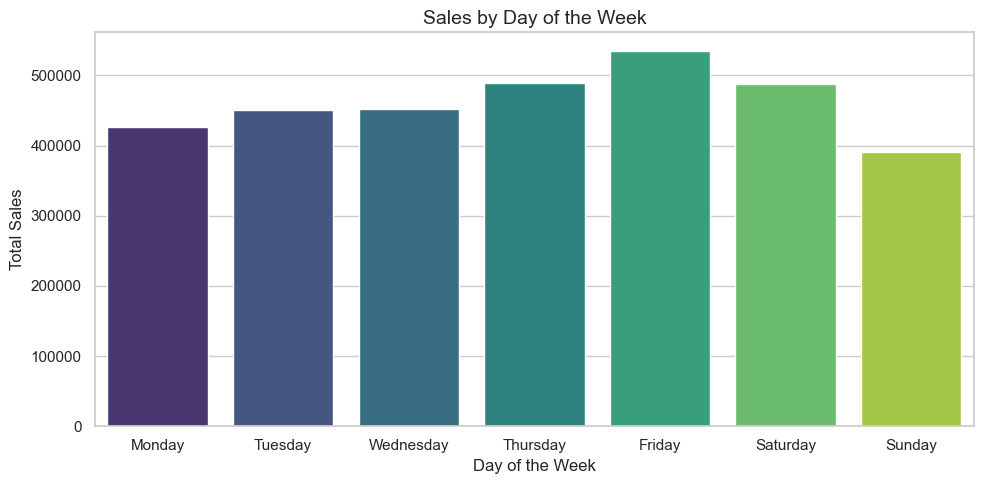

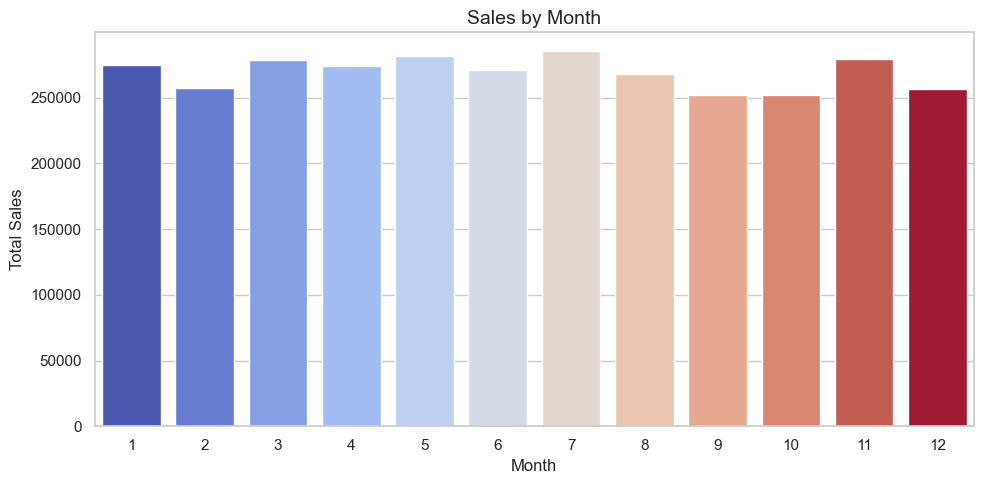

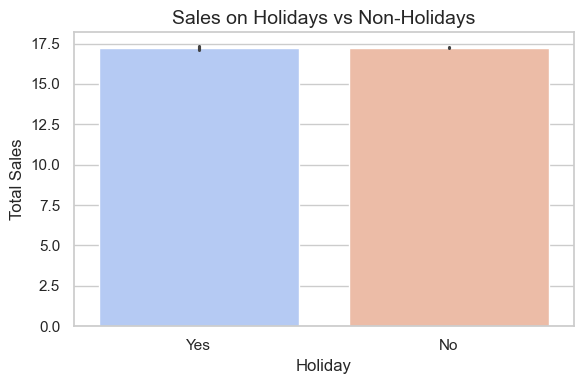

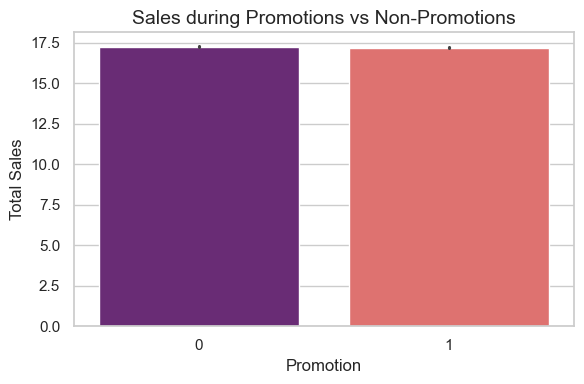

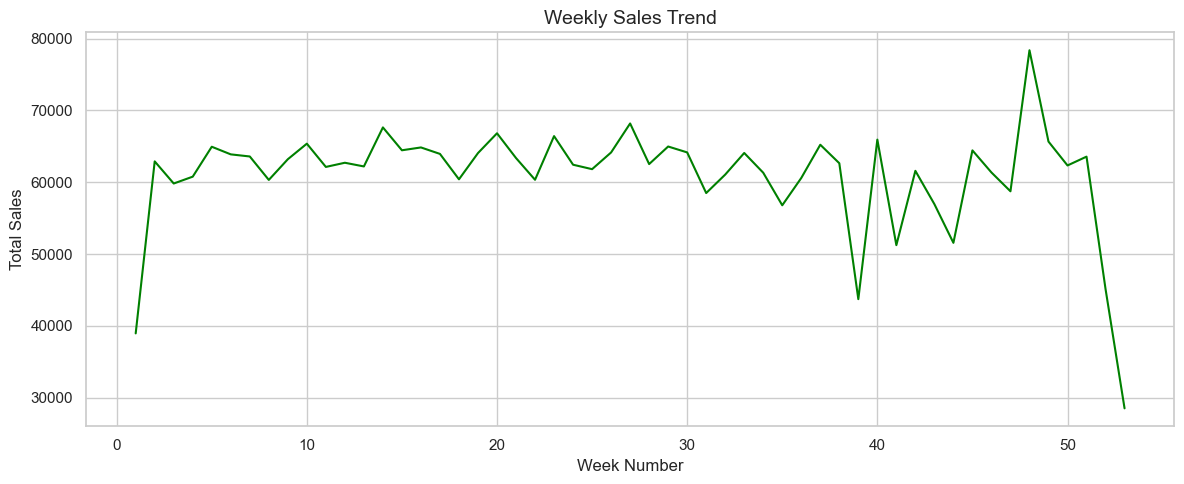

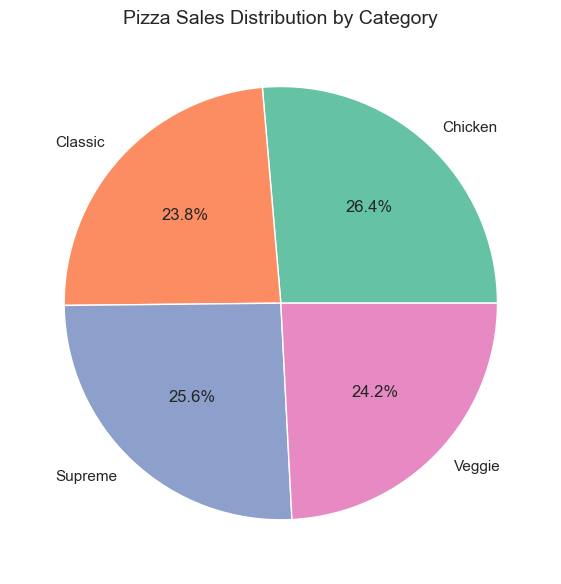

In [25]:
# Set plot style
sns.set(style="whitegrid")

# Ensure 'order_date' is datetime
merged['order_date'] = pd.to_datetime(merged['order_date'])

# -------------------------------
# Total Sales Over Time (Area Chart)
# -------------------------------
sales_over_time = merged.groupby('order_date')['total_price'].sum().reset_index()

plt.figure(figsize=(14, 6))
plt.fill_between(sales_over_time['order_date'], sales_over_time['total_price'], color='lightblue', alpha=0.4)
plt.plot(sales_over_time['order_date'], sales_over_time['total_price'], color='blue', linewidth=1)
plt.title('Total Sales Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# Sales by Pizza Size
# -------------------------------
size_sales = merged.groupby('pizza_size')['quantity'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=size_sales, x='pizza_size', y='quantity', hue='pizza_size', palette='viridis', legend=False)
plt.title('Sales by Pizza Size', fontsize=14)
plt.xlabel('Pizza Size')
plt.ylabel('Quantity Sold')
plt.tight_layout()
plt.show()

# -------------------------------
# Sales by Pizza Category
# -------------------------------
category_sales = merged.groupby('pizza_category')['quantity'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=category_sales, x='pizza_category', y='quantity',hue='pizza_category', palette='magma',legend=False)
plt.title('Sales by Pizza Category', fontsize=14)
plt.xlabel('Pizza Category')
plt.ylabel('Quantity Sold')
plt.tight_layout()
plt.show()

# -------------------------------
# Sales by Pizza Name
# -------------------------------
pizza_sales = merged.groupby('pizza_name')['quantity'].sum().reset_index()
pizza_sales = pizza_sales.sort_values(by='quantity', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(data=pizza_sales, x='quantity', y='pizza_name', hue='pizza_name', palette='plasma', legend=False)
plt.title('Sales by Pizza Name', fontsize=14)
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.tight_layout()
plt.show()

# -------------------------------
# Top 10 Most Popular Pizzas
# -------------------------------
top10_pizza_sales = pizza_sales.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top10_pizza_sales, x='quantity', y='pizza_name',hue='pizza_name', palette='cividis', legend=False)
plt.title('Top 10 Most Popular Pizzas', fontsize=14)
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.tight_layout()
plt.show()

# -------------------------------
# Sales by Day of the Week
# -------------------------------
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_by_day = merged.groupby('day_of_week')['total_price'].sum().reset_index()
sales_by_day['day_name'] = sales_by_day['day_of_week'].apply(lambda x: day_labels[x])
sales_by_day = sales_by_day.sort_values('day_of_week')

plt.figure(figsize=(10, 5))
sns.barplot(data=sales_by_day, x='day_name', y='total_price',hue='day_name', palette='viridis', legend=False)
plt.title('Sales by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

# -------------------------------
# Sales by Month
# -------------------------------
sales_by_month = merged.groupby('month')['total_price'].sum().reset_index()
sales_by_month = sales_by_month.sort_values('month')

plt.figure(figsize=(10, 5))
sns.barplot(data=sales_by_month, x='month', y='total_price',hue='month', palette='coolwarm',legend=False)
plt.title('Sales by Month', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

# -------------------------------
# Sales on Holidays vs Non-Holidays
# -------------------------------
plt.figure(figsize=(6, 4))
sns.barplot(x='holiday', y='total_price', hue='holiday',data=merged, palette='coolwarm', legend=False)
plt.title('Sales on Holidays vs Non-Holidays', fontsize=14)
plt.xlabel('Holiday')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

# -------------------------------
# Sales during Promotions vs Non-Promotions
# -------------------------------
plt.figure(figsize=(6, 4))
sns.barplot(x='promotion', y='total_price', hue='promotion',data=merged, palette='magma', legend=False)
plt.title('Sales during Promotions vs Non-Promotions', fontsize=14)
plt.xlabel('Promotion')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

# -------------------------------
# Weekly Sales Trend
# -------------------------------
merged['week'] = merged['order_date'].dt.isocalendar().week
weekly_sales = merged.groupby('week')['total_price'].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=weekly_sales, x='week', y='total_price', color='green')
plt.title("Weekly Sales Trend", fontsize=14)
plt.xlabel("Week Number")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

# -------------------------------
# Pie Chart - Pizza Category Distribution
# -------------------------------
plt.figure(figsize=(6, 6))
category_sales.set_index('pizza_category')['quantity'].plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Pizza Sales Distribution by Category', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()


# MODEL SELECTION

In [26]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.linear_model import LinearRegression
import itertools
import warnings
warnings.filterwarnings("ignore")

# === 1. Load and Prepare Data ===
merged['order_date'] = pd.to_datetime(merged['order_date'])
daily_sales = merged.groupby('order_date')['quantity'].sum().reset_index()

def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    return df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()

weekly_sales = prepare_weekly_sales(merged)

train_size = int(0.8 * len(weekly_sales))
train, test = weekly_sales[:train_size], weekly_sales[train_size:]

# Evaluation Metric : MAPE (Mean Absolute Percentage Error)
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100


# ARIMA

ARIMA Best Params: (2, 0, 2), MAPE: 18.94%
Predictions:
order_date
2015-10-19    3355.539322
2015-10-26    3550.041985
2015-11-02    3678.106924
2015-11-09    3708.335715
2015-11-16    3678.904010
2015-11-23    3638.605701
2015-11-30    3614.951494
2015-12-07    3611.314408
2015-12-14    3618.525737
2015-12-21    3626.721755
2015-12-28    3630.987206
Name: predicted_mean, dtype: float64


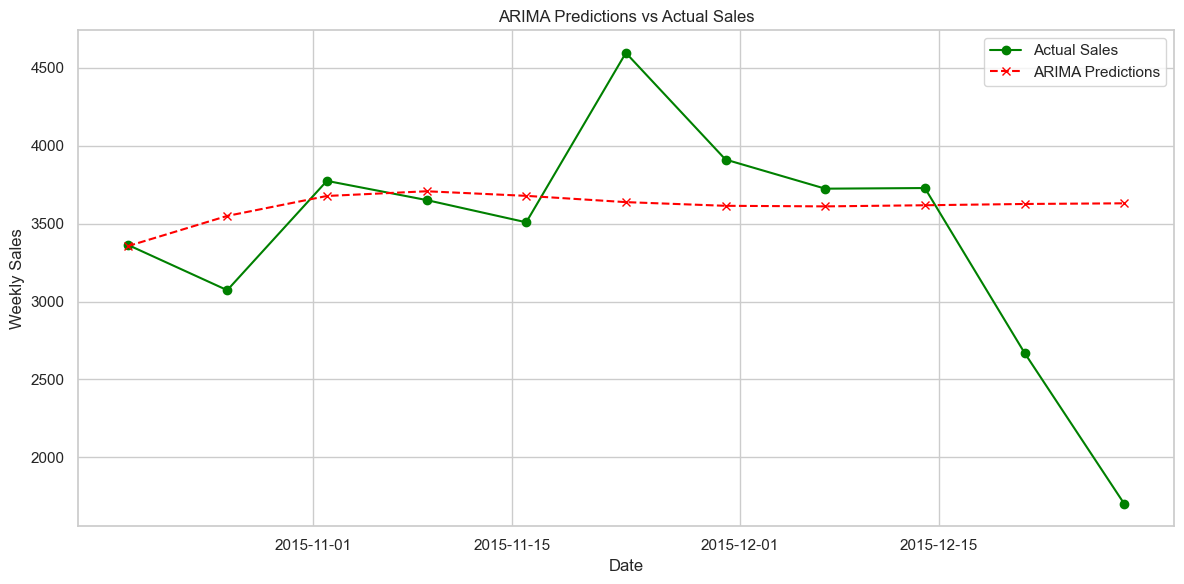

In [10]:
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

def arima_forecast(train, test, p_vals, d_vals, q_vals):
    best_score, best_preds, best_params = float('inf'), None, None
    for p, d, q in itertools.product(p_vals, d_vals, q_vals):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            preds = model.forecast(steps=len(test))
            score = mape(test, preds)
            if score < best_score:
                best_score, best_preds, best_params = score, preds, (p, d, q)
        except:
            continue
    print(f"ARIMA Best Params: {best_params}, MAPE: {best_score:.2f}%")
    return pd.Series(best_preds, index=test.index)

arima_preds = arima_forecast(train, test, range(0, 3), range(0, 2), range(0, 3))

# Print predictions in your desired format
print("Predictions:")
print(arima_preds)

# Simple Plot: Actual vs Predicted on Test Set only
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='green', marker='o')
plt.plot(arima_preds.index, arima_preds, label='ARIMA Predictions', color='red', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SARIMA

SARIMA MAPE: 18.49%
Predictions:
order_date
2015-10-19    3251.272756
2015-10-26    3647.832491
2015-11-02    3407.750842
2015-11-09    2751.018165
2015-11-16    3590.624607
2015-11-23    3085.587807
2015-11-30    3327.776367
2015-12-07    3156.542364
2015-12-14    3476.427042
2015-12-21    3266.878644
2015-12-28    2594.200829
Name: predicted_mean, dtype: float64


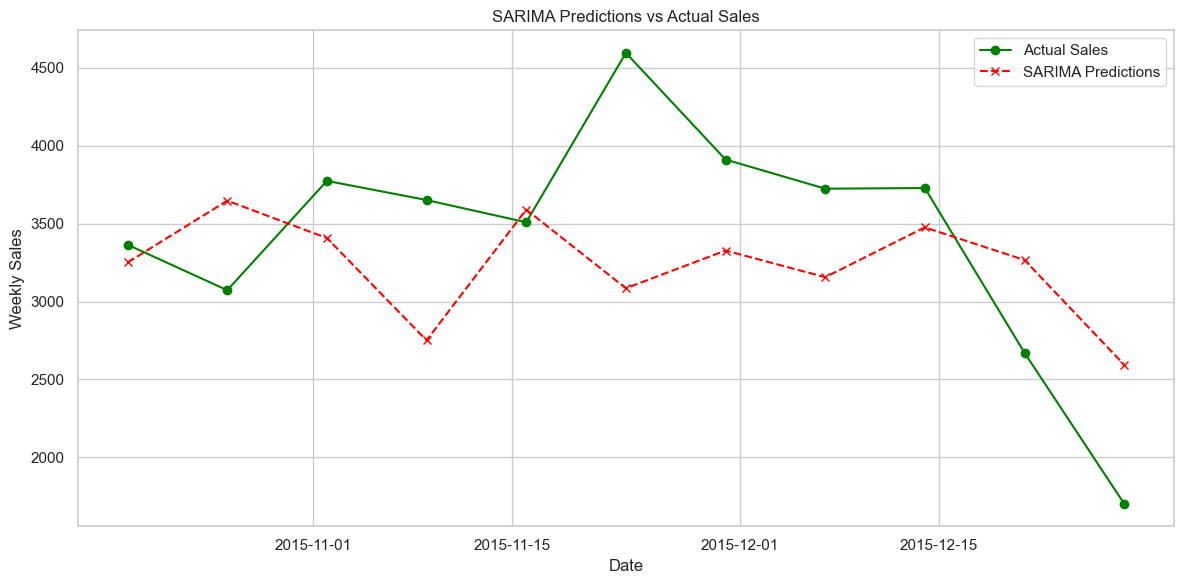

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

def sarima_forecast(train, test):
    model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7)).fit()
    preds = model.forecast(steps=len(test))
    score = mape(test, preds)
    print(f"SARIMA MAPE: {score:.2f}%")
    return pd.Series(preds, index=test.index)

sarima_preds = sarima_forecast(train, test)

# Print predictions in your desired format
print("Predictions:")
print(sarima_preds)

# Simple Plot: Actual vs Predicted on Test Set only
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='green', marker='o')
plt.plot(sarima_preds.index, sarima_preds, label='SARIMA Predictions', color='red', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Prophet

11:09:40 - cmdstanpy - INFO - Chain [1] start processing
11:09:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE: 19.62%
Predictions:
ds
2015-10-18    3619.861577
2015-10-25    3618.432781
2015-11-01    3617.003986
2015-11-08    3615.575190
2015-11-15    3614.146395
2015-11-22    3612.717599
2015-11-29    3611.288804
2015-12-06    3609.860008
2015-12-13    3608.431213
2015-12-20    3607.002417
2015-12-27    3605.573622
Name: yhat, dtype: float64


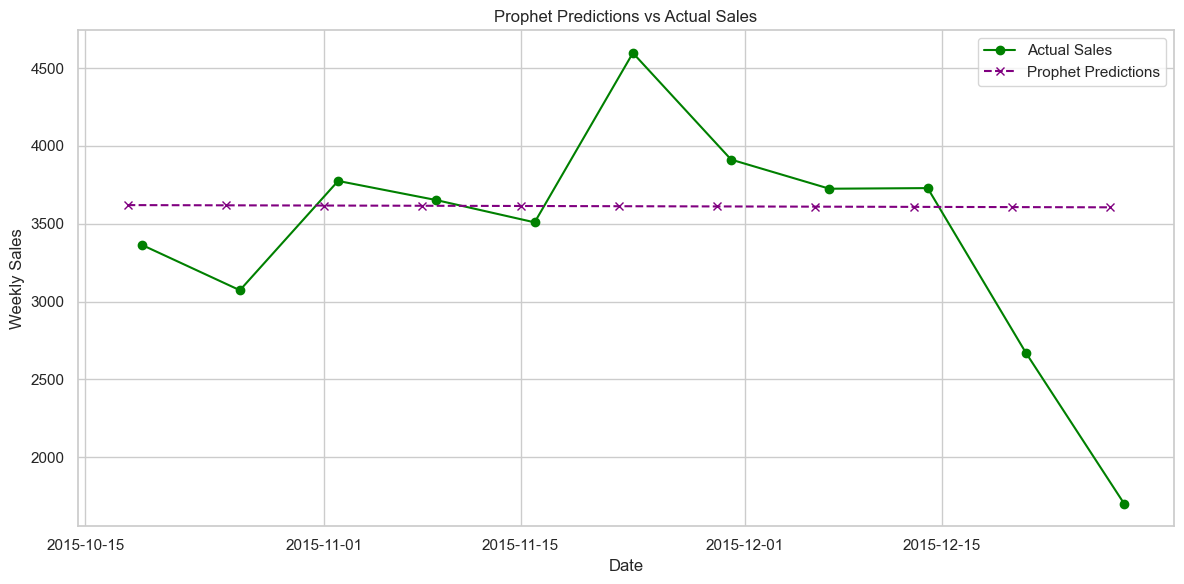

In [12]:
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Prepare weekly data for Prophet
prophet_df = weekly_sales.reset_index()
prophet_df.columns = ['ds', 'y']   # ds-datestamp(x-axis), y-value to forecast(y-axis)
train_df = prophet_df[:train_size]
test_df = prophet_df[train_size:]

# Fit and predict
model = Prophet()
model.fit(train_df)
future = model.make_future_dataframe(periods=len(test_df), freq='W')
forecast = model.predict(future)

# Extract predictions for test period
prophet_preds = forecast[['ds', 'yhat']].set_index('ds').iloc[-len(test_df):]['yhat']

# Calculate and print MAPE
score = mape(test_df['y'].values, prophet_preds.values)
print(f"Prophet MAPE: {score:.2f}%")

# Print predictions like your format
print("Predictions:")
print(prophet_preds)

# Simple plot: actual vs predicted on test set only
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], test_df['y'], label='Actual Sales', color='green', marker='o')
plt.plot(prophet_preds.index, prophet_preds.values, label='Prophet Predictions', color='purple', linestyle='--', marker='x')
plt.title('Prophet Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Linear Regression

Linear Regression MAPE: 19.11%
Predictions:
ds
2015-10-19    3545.287304
2015-10-26    3530.562085
2015-11-02    3552.361183
2015-11-09    3537.635964
2015-11-16    3522.910745
2015-11-23    3508.185526
2015-11-30    3493.460307
2015-12-07    3515.259404
2015-12-14    3500.534185
2015-12-21    3485.808966
2015-12-28    3471.083747
dtype: float64


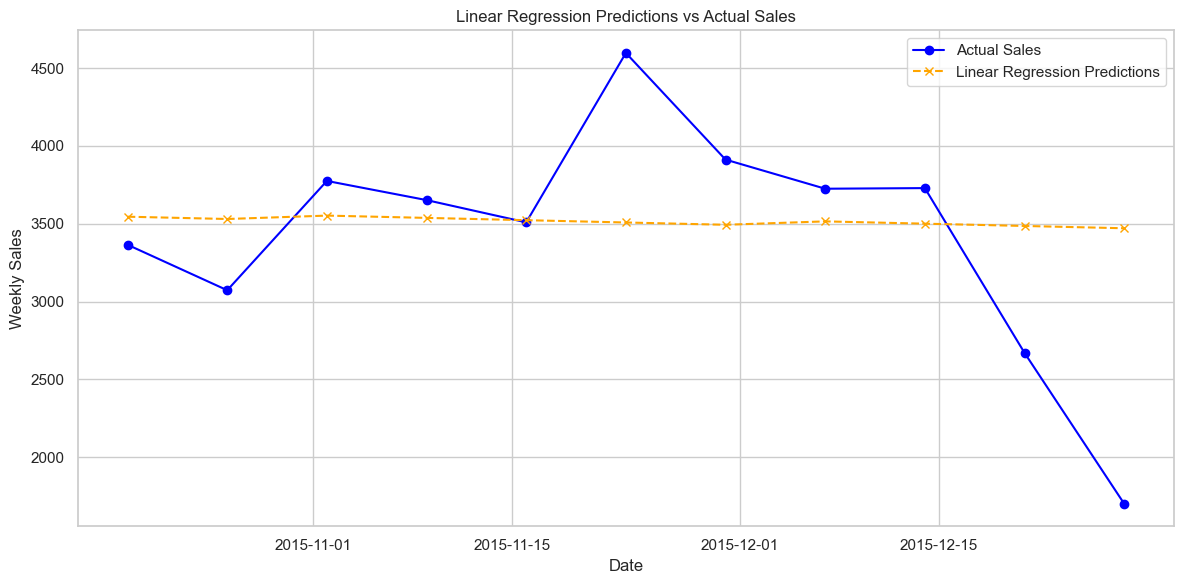

In [13]:
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Feature engineering
def create_features(df):
    df['week'] = df['ds'].dt.isocalendar().week
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    return df

weekly_feat_df = create_features(prophet_df.copy())

X = weekly_feat_df[['week', 'month', 'year']]
y = weekly_feat_df['y']
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train and predict
model = LinearRegression()
model.fit(X_train, y_train)
lr_preds = model.predict(X_test)

# Calculate MAPE
score = mape(y_test, lr_preds)
print(f"Linear Regression MAPE: {score:.2f}%")

# Format predictions as Series with test_df index for printing
lr_preds_series = pd.Series(lr_preds, index=test_df['ds'])

print("Predictions:")
print(lr_preds_series)

# Plot actual vs predicted values on test set only
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], y_test, label='Actual Sales', color='blue', marker='o')
plt.plot(test_df['ds'], lr_preds, label='Linear Regression Predictions', color='orange', linestyle='--', marker='x')
plt.title('Linear Regression Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Model Selection

In [14]:
model_performance = {
    'ARIMA': mape(test, arima_preds),
    'SARIMA': mape(test, sarima_preds),
    'Prophet': mape(test_df['y'].values, prophet_preds.values),
    'Linear Regression': mape(y_test, lr_preds)
}

best_model = min(model_performance, key=model_performance.get)
print("\nModel Performance (MAPE):")
for model, score in model_performance.items():
    print(f"{model}: {score:.2f}%")
print(f"\nBest model: {best_model}")



Model Performance (MAPE):
ARIMA: 18.94%
SARIMA: 18.49%
Prophet: 19.62%
Linear Regression: 19.11%

Best model: SARIMA


# Model Evaluation


Final MAPE Scores:
ARIMA MAPE: 18.94%
SARIMA MAPE: 18.49%
Prophet MAPE: 19.62%
Linear Regression MAPE: 19.11%


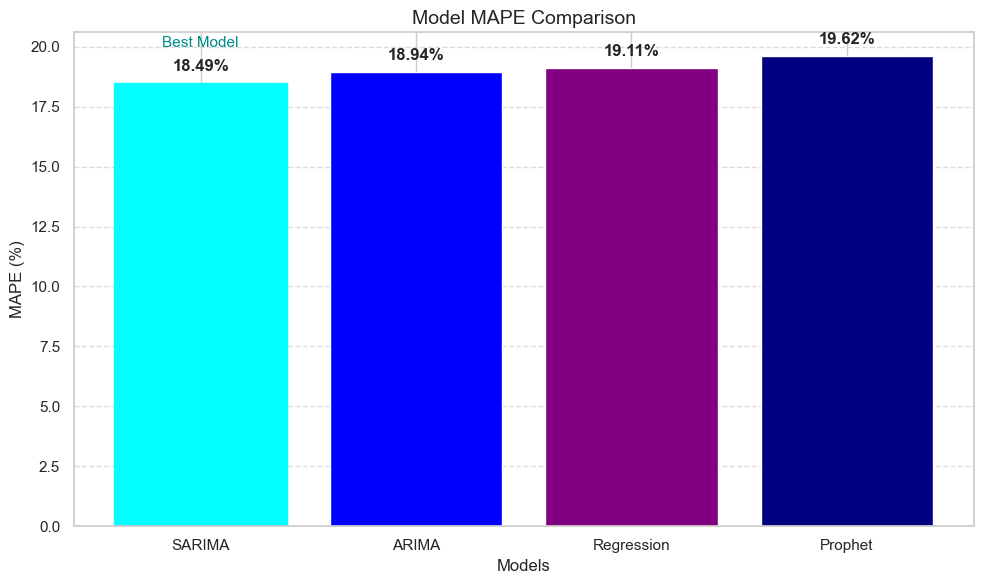

In [27]:
# === Final MAPE Comparison Bar Chart ===


# Collect MAPE scores from previous steps
arima_mape = mape(test, arima_preds)
sarima_mape = mape(test, sarima_preds)
prophet_mape = mape(test_df['y'].values, prophet_preds.values)
regression_mape = mape(y_test, lr_preds)

# Print all MAPEs for clarity
print(f"\nFinal MAPE Scores:")
print(f"ARIMA MAPE: {arima_mape:.2f}%")
print(f"SARIMA MAPE: {sarima_mape:.2f}%")
print(f"Prophet MAPE: {prophet_mape:.2f}%")
print(f"Linear Regression MAPE: {regression_mape:.2f}%")

# Prepare data for bar chart
models = ['SARIMA', 'ARIMA', 'Regression', 'Prophet']
mapes = [sarima_mape, arima_mape, regression_mape, prophet_mape]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(models, mapes, color=['green', 'blue', 'purple', 'navy'])

# Highlight the best model
best_index = mapes.index(min(mapes))
bars[best_index].set_color('cyan')

# Add MAPE values above bars
for i, v in enumerate(mapes):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', fontweight='bold')

# Annotate best
plt.text(best_index, mapes[best_index] + 1.5, 'Best Model', ha='center', fontsize=11, color='darkcyan')

# Chart titles and labels
plt.title('Model MAPE Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Sales Forcasting 

In [16]:
# 1. Aggregate pizza sales weekly by pizza type
def get_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    return weekly_sales.set_index('week')

# 2. Forecast sales for a given pizza type using SARIMA
def sarima_forecast(train_series, steps=1):
    model = SARIMAX(train_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)
    return model_fit.forecast(steps=steps).iloc[0]  # Return just the first forecast value

# 3. Forecast sales for all pizza types for next week
def forecast_next_week(weekly_sales_df):
    forecasts = {}
    grouped = weekly_sales_df.groupby('pizza_name_id')

    last_week = weekly_sales_df.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    for pizza, group in grouped:
        series = group['quantity']
        train_size = int(len(series) * 0.8)
        train = series.iloc[:train_size]
        forecast_qty = sarima_forecast(train)
        forecasts[pizza] = int(round(forecast_qty))

    return forecasts, next_week_start, next_week_end

# Run the forecasting pipeline
weekly_sales = get_weekly_sales(merged)
pizza_forecasts, start_date, end_date = forecast_next_week(weekly_sales)

# 4. Display results
print(f"Forecasted sales for the week {start_date.date()} to {end_date.date()}:")
total_forecast = 0
for pizza, qty in pizza_forecasts.items():
    print(f"{pizza}: {qty} pizzas")
    total_forecast += qty

print(f"\nTotal quantity of units sold in the predicted week: {total_forecast} pizzas")


Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 83 pizzas
bbq_ckn_m: 95 pizzas
bbq_ckn_s: 39 pizzas
big_meat_s: 90 pizzas
brie_carre_s: 56 pizzas
calabrese_l: 12 pizzas
calabrese_m: 41 pizzas
calabrese_s: 6 pizzas
cali_ckn_l: 83 pizzas
cali_ckn_m: 56 pizzas
cali_ckn_s: 38 pizzas
ckn_alfredo_l: 9 pizzas
ckn_alfredo_m: 58 pizzas
ckn_alfredo_s: 11 pizzas
ckn_pesto_l: 32 pizzas
ckn_pesto_m: 14 pizzas
ckn_pesto_s: 14 pizzas
classic_dlx_l: 19 pizzas
classic_dlx_m: 72 pizzas
classic_dlx_s: 39 pizzas
five_cheese_l: 55 pizzas
four_cheese_l: 151 pizzas
four_cheese_m: 44 pizzas
green_garden_l: 3 pizzas
green_garden_m: 28 pizzas
green_garden_s: 47 pizzas
hawaiian_l: 48 pizzas
hawaiian_m: 21 pizzas
hawaiian_s: 46 pizzas
ital_cpcllo_l: 60 pizzas
ital_cpcllo_m: 38 pizzas
ital_cpcllo_s: 26 pizzas
ital_supr_l: 62 pizzas
ital_supr_m: 49 pizzas
ital_supr_s: 4 pizzas
ital_veggie_l: 17 pizzas
ital_veggie_m: 25 pizzas
ital_veggie_s: 16 pizzas
mediterraneo_l: 38 pizzas
mediterraneo_m: 29 p

# Ingredient Calculation

In [17]:
# Assuming 'Ingredients_data' is your DataFrame with columns:
# 'pizza_name_id', 'pizza_ingredients', 'Items_Qty_In_Grams'

# 1. Copy ingredients dataframe
ingredients_predicted = ingredients.copy()

# 2. Map predicted pizza sales quantity from SARIMA forecast dictionary
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(pizza_forecasts)

# 3. Calculate total ingredient quantity needed for predicted pizza sales
ingredients_predicted['total_ingredient_qty'] = (
    ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']
)

# 4. Aggregate total quantity per ingredient (sum over all pizzas)
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()

# 5. Print the ingredient totals forecast
print("Total quantity of predicted ingredients for the following week:")
for ingredient, total_qty in ingredient_totals.items():
    print(f"{ingredient}: {total_qty:.2f} grams")

# Optional: display the dataframe for detailed info
ingredients_predicted


Total quantity of predicted ingredients for the following week:
?duja Salami: 2480.00 grams
Alfredo Sauce: 1160.00 grams
Anchovies: 2870.00 grams
Artichokes: 9460.00 grams
Arugula: 775.00 grams
Asiago Cheese: 5890.00 grams
Bacon: 24930.00 grams
Barbecue Sauce: 2390.00 grams
Barbecued Chicken: 6950.00 grams
Beef Chuck Roast: 11650.00 grams
Blue Cheese: 1650.00 grams
Brie Carre Cheese: 1680.00 grams
Calabrese Salami: 14400.00 grams
Capocollo: 58350.00 grams
Caramelized Onions: 896.00 grams
Chicken: 78450.00 grams
Chipotle Sauce: 7270.00 grams
Chorizo Sausage: 4500.00 grams
Cilantro: 3635.00 grams
Coarse Sicilian Salami: 12640.00 grams
Corn: 24270.00 grams
Eggplant: 2340.00 grams
Feta Cheese: 10630.00 grams
Fontina Cheese: 5200.00 grams
Friggitello Peppers: 620.00 grams
Garlic: 23355.00 grams
Genoa Salami: 8130.00 grams
Goat Cheese: 12160.00 grams
Gorgonzola Piccante Cheese: 6920.00 grams
Gouda Cheese: 3990.00 grams
Green Olives: 4600.00 grams
Green Peppers: 6590.00 grams
Italian Sausage:

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,predicted_quantity,total_ingredient_qty
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,83,3320.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,83,1245.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,83,1660.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,83,2490.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,83,4980.0
...,...,...,...,...,...,...
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0,41,820.0
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0,41,820.0
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0,41,410.0
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0,41,615.0


In [18]:
# Saving the ingredient totals to a DataFrame
ingredient_totals_df = pd.DataFrame(
    list(ingredient_totals.items()), 
    columns=['Ingredient', 'Total Quantity (grams)']
)

# Save to CSV without the index column
ingredient_totals_df.to_csv('predicted_ingredient_totals.csv', index=False)

print("Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'")

predicted_ingredient_totals = pd.read_csv('predicted_ingredient_totals.csv')
predicted_ingredient_totals


Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'


,Ingredient,Total Quantity (grams)
0,?duja Salami,2480.0
1,Alfredo Sauce,1160.0
2,Anchovies,2870.0
3,Artichokes,9460.0
4,Arugula,775.0
...,...,...
59,Sun-dried Tomatoes,1460.0
60,Thai Sweet Chilli Sauce,4270.0
61,Thyme,280.0
62,Tomatoes,46120.0


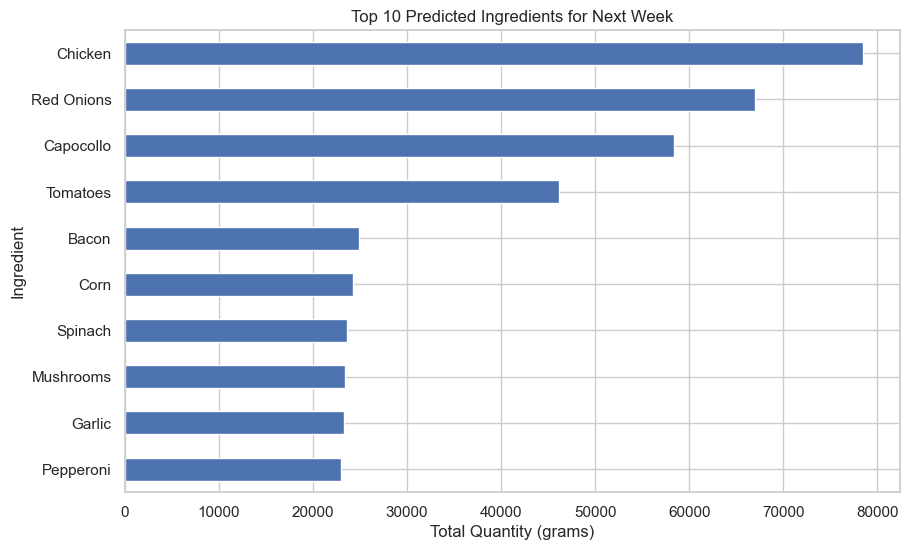

In [19]:
ingredient_totals_df.nlargest(10, 'Total Quantity (grams)').plot(
    kind='barh', x='Ingredient', y='Total Quantity (grams)', legend=False, figsize=(10,6)
)
plt.title('Top 10 Predicted Ingredients for Next Week')
plt.xlabel('Total Quantity (grams)')
plt.ylabel('Ingredient')
plt.gca().invert_yaxis()  # To show the largest at top
plt.show()


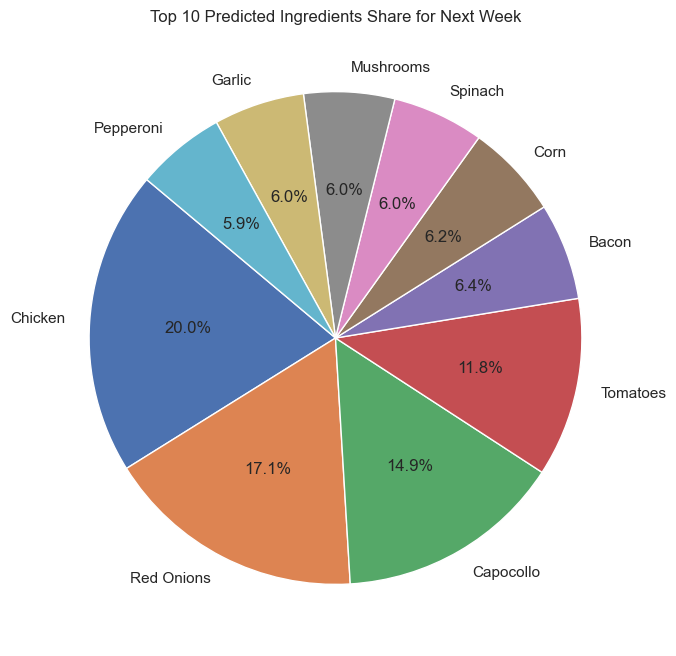

In [21]:
top_ingredients = ingredient_totals_df.nlargest(10, 'Total Quantity (grams)')
plt.figure(figsize=(8,8))
plt.pie(top_ingredients['Total Quantity (grams)'], labels=top_ingredients['Ingredient'], autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Predicted Ingredients Share for Next Week')
plt.show()
